In [16]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy
from math import sqrt

In [7]:
derivation_cohort = pd.read_csv("Derivation_dataset.csv")
external_validation_cohort = pd.read_csv("External_validation_dataset.csv")

In [8]:
derivation_cohort.head()

,Outcome_Occlusion_MI,Age,HR,PR,QRSd,mfpQRSaxis,fpTaxis,txzQRSaxis,QRSTangle,mQRSTangle,...,tamp_III,tamp_aVR,tamp_aVL,tamp_aVF,tamp_V1,tamp_V2,tamp_V3,tamp_V4,tamp_V5,tamp_V6
0,0,78.0,116.0,94.0,107.0,7.0,107.0,79.0,163.0,142.0,...,46.0,0.0,-61.0,63.0,132.0,201.0,319.0,125.0,59.0,-65.0
1,0,84.0,71.0,174.0,136.0,53.0,NaN,51.0,137.0,113.0,...,69.0,51.0,32.0,-72.0,344.0,742.0,668.0,172.0,-153.0,23.0
2,0,76.0,73.0,191.0,110.0,-72.0,56.0,110.0,153.0,147.0,...,50.0,-131.0,29.0,103.0,-50.0,81.0,186.0,155.0,101.0,60.0
3,0,53.0,76.0,134.0,97.0,71.0,58.0,117.0,50.0,78.0,...,195.0,-249.0,-38.0,266.0,-101.0,89.0,450.0,545.0,656.0,272.0
4,0,34.0,76.0,160.0,87.0,43.0,70.0,26.0,45.0,38.0,...,169.0,-150.0,-59.0,199.0,75.0,192.0,128.0,103.0,127.0,150.0


In [9]:
external_validation_cohort.head()

,Outcome_Occlusion_MI,Age,HR,PR,QRSd,mfpQRSaxis,fpTaxis,txzQRSaxis,QRSTangle,mQRSTangle,...,tamp_III,tamp_aVR,tamp_aVL,tamp_aVF,tamp_V1,tamp_V2,tamp_V3,tamp_V4,tamp_V5,tamp_V6
0,0,64,98,NaN,128,35,14.0,-108,23.0,82.0,...,-105,-176,151,80,-242,-129,-98,272,307,270
1,1,64,76,166.0,95,3,98.0,111,56.0,83.0,...,136,77,-129,143,198,386,469,-147,-140,-106
2,0,55,65,NaN,125,-77,63.0,76,137.0,134.0,...,138,-166,21,186,-159,178,186,144,107,85
3,0,58,67,248.0,79,79,44.0,28,32.0,38.0,...,48,-102,-22,84,-33,89,205,179,115,58
4,0,40,111,140.0,103,54,-22.0,-179,27.0,17.0,...,-108,-51,112,-8,-53,29,87,129,-77,-62


In [10]:
y = derivation_cohort['Outcome_Occlusion_MI']
X = derivation_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 99)

y_val = external_validation_cohort['Outcome_Occlusion_MI']
X_val = external_validation_cohort.drop('Outcome_Occlusion_MI', axis=1)

for el in X_train.columns:
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    X_test[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
y_test = np.ravel(np.array(y_test.values))
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

X_train = np.array(X_train.values)
X_test = np.array(X_test.values)
X_val = np.array(X_val.values)

scaler = preprocessing.StandardScaler().fit(X_train) # Compute mean and std of training set
X_train = scaler.transform(X_train, copy=True)
X_test = scaler.transform(X_test, copy=True) # Standardize X_test using training mean and std
X_val = scaler.transform(X_val, copy=True)

C:\Users\arthu\AppData\Local\Temp\ipykernel_4676\3933838254.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_4676\3933838254.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

In [11]:
def train_clf_RF(n_estimators=20):
    clf = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', n_jobs=-1, random_state=42,
                            max_features='log2', 
                            n_estimators=n_estimators,
                            min_samples_split=0.01,
                            min_samples_leaf=0.005,
                            min_impurity_decrease=1e-2,
                            bootstrap=True,
                            ccp_alpha=1e-2,
                            max_samples=0.75,
                            oob_score=True)
    clf = CalibratedClassifierCV(clf, cv=5, method="isotonic")
    return clf

In [12]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'RF (AUC = %0.3f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    y_pred = np.where(OMI_score<5, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=20, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))

In [14]:
'''
def plot_Shapley(clf, df_test, cols, set_name, nf): #nf = number of features
    #Load JS visualization code to notebook
    shap.initjs()
    
    #Shapley explainability
    plt.figure()
    df = pd.DataFrame(data=df_test, columns=(cols))
    
    shap_values_list = []
    for calibrated_classifier in clf.calibrated_classifiers_:
        explainer = shap.TreeExplainer(calibrated_classifier.base_estimator)
        shap_values = explainer.shap_values(df)
        shap_values_list.append(shap_values)
    shap_values = np.array(shap_values_list).sum(axis=0) / len(shap_values_list)
    
    shap.summary_plot(shap_values[1], features=df, feature_names=np.array(cols), sort=True, show=False, max_display=nf, color_bar=False, plot_type='dot', plot_size=(5.00, 10.00))
    plt.title('Shapley values of the top '+str(nf)+'/'+str(len(cols))+' features for OMI prediction (derivation cohort)', fontweight="bold")
    plt.show()
'''

'\ndef plot_Shapley(clf, df_test, cols, set_name, nf): #nf = number of features\n    #Load JS visualization code to notebook\n    shap.initjs()\n    \n    #Shapley explainability\n    plt.figure()\n    df = pd.DataFrame(data=df_test, columns=(cols))\n    \n    shap_values_list = []\n    for calibrated_classifier in clf.calibrated_classifiers_:\n        explainer = shap.TreeExplainer(calibrated_classifier.base_estimator)\n        shap_values = explainer.shap_values(df)\n        shap_values_list.append(shap_values)\n    shap_values = np.array(shap_values_list).sum(axis=0) / len(shap_values_list)\n    \n    shap.summary_plot(shap_values[1], features=df, feature_names=np.array(cols), sort=True, show=False, max_display=nf, color_bar=False, plot_type=\'dot\', plot_size=(5.00, 10.00))\n    plt.title(\'Shapley values of the top \'+str(nf)+\'/\'+str(len(cols))+\' features for OMI prediction (derivation cohort)\', fontweight="bold")\n    plt.show()\n'

In [21]:
print("Train")
start_estimator = 300
max_estimator = 500
recall_train = []
recall_test = []

# Create progress bar for long running process
from tqdm import tqdm

for i in tqdm(range(start_estimator, max_estimator)):
    clf = train_clf_RF(i)
    clf.fit(X_train, y_train)
    pred_probas_train = clf.predict_proba(X_train)
    risk_groups_train = results(pred_probas_train)
    
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train[:,1])
    roc_auc = auc(fpr, tpr)
    #roc_auc_list_train.append(roc_auc)
    y_pred_clinical = (pred_probas_train[:,1] >= 0.20).astype(int)
    recall_clinical = recall_score(y_train, y_pred_clinical)
    recall_train.append(recall_clinical)
    
    #print("current rauc is: ", roc_auc)
    #compute test portion
    pred_probas_test = clf.predict_proba(X_test)
    risk_groups_test = results(pred_probas_test)
    fpr, tpr, thresholds = roc_curve(y_test, pred_probas_test[:,1])
    roc_auc = auc(fpr, tpr)
    y_pred_clinical = (pred_probas_test[:,1] >= 0.20).astype(int)
    recall_clinical = recall_score(y_test, y_pred_clinical)
    recall_test.append(recall_clinical)


Train


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [12:40<00:00,  3.80s/it]


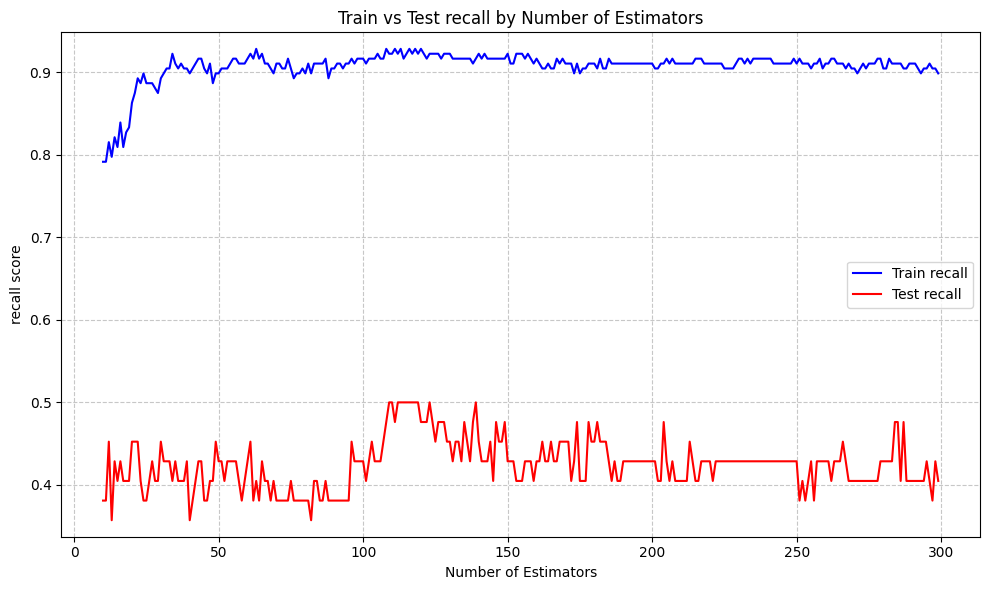


Best Test recall: 0.5000 (n_estimators = 109)


In [20]:
import matplotlib.pyplot as plt

# Create array of estimator values for x-axis
estimator_range = range(start_estimator, max_estimator)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, recall_train, label='Train recall', color='blue')
plt.plot(estimator_range, recall_test, label='Test recall', color='red')

# Customize the plot
plt.xlabel('Number of Estimators')
plt.ylabel('recall score')
plt.title('Train vs Test recall by Number of Estimators')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Optional: Set y-axis limits slightly above and below the data range
plt.ylim(min(min(recall_train), min(recall_test)) - 0.02,
         max(max(recall_train), max(recall_test)) + 0.02)

# Show the plot
plt.tight_layout()
plt.show()

# Print the best test AUC and corresponding number of estimators
best_test_recall = max(recall_test)
best_n_estimators = recall_test.index(best_test_recall) + start_estimator
print(f"\nBest Test recall: {best_test_recall:.4f} (n_estimators = {best_n_estimators})")

In [45]:
clf = train_clf_RF(180)
clf.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=RandomForestClassifier(ccp_alpha=0.01,
                                                        class_weight='balanced_subsample',
                                                        criterion='entropy',
                                                        max_features='log2',
                                                        max_samples=0.75,
                                                        min_impurity_decrease=0.01,
                                                        min_samples_leaf=0.005,
                                                        min_samples_split=0.01,
                                                        n_estimators=180,
                                                        n_jobs=-1,
                                                        oob_score=True,
                                                        random_state=42),
                       method='isotonic')

In [46]:
risk_groups_train.head()

,Low risk,Intermediate risk,High risk
Count (N),2521,472,227


Test


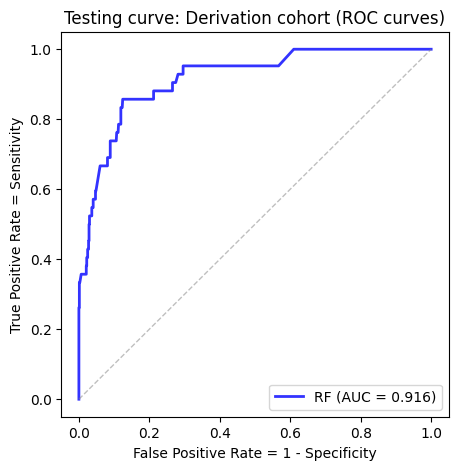

In [47]:
print('Test')
pred_probas_test = clf.predict_proba(X_test)
risk_groups_test = results(pred_probas_test)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, pred_probas_test[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Testing curve: Derivation cohort (ROC curves)')

#plot_Shapley(clf, X_test, columns, 'Derivation cohort', 25)

In [48]:
risk_groups_test.head()

,Low risk,Intermediate risk,High risk
Count (N),613,153,40


External Validation


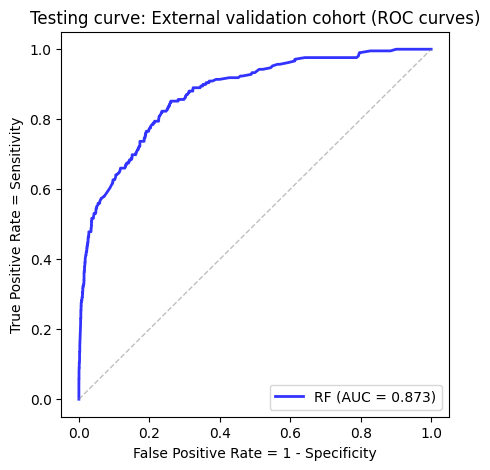

In [49]:
print("External Validation")
pred_probas_val = clf.predict_proba(X_val)
risk_groups_val = results(pred_probas_val)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_val, pred_probas_val[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Testing curve: External validation cohort (ROC curves)')

In [26]:
risk_groups_val.head()

,Low risk,Intermediate risk,High risk
Count (N),2318,747,222
